# Image classification of Breast Ultra Sound Images

Here we experiment with classical algorithms such as Logistic Regression, SVM and Bag of Visual words


### Import packages

In [12]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

### Functions to assess model quality and to plot confusion matrix, ROC etc.

In [36]:
# Plot confusion matrix (binary)
def plot_cm(cm):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.title("Confusion matrix")
    plt.show()
    

# Plot ROC
def plot_ROC(fpr, tpr, auc):

    plt.figure(figsize = (6.4, 6.4))
    plt.plot(fpr, tpr, label= f"ROC, auc= {auc:.2f}")
    plt.title("ROC curve")
    plt.legend(loc=4)
    plt.show()
    

# To assess model quality analysis
def model_quality(model, X_train, X_test, y_train, y_test):

    # Accuracy
    print(f"Model accuracy on training data: {model.score(X_train, y_train):.2f} ")
    print(f"Model accuracy on test data: {model.score(X_test, y_test):.2f} ")

    # Classification report (precision, recall, f1 score)
    print(f"\nClassification report:\n {classification_report(y_test, model.predict(X_test))} ")

    # Confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print(f"Confusion matrix:\n {cm}\n")
    plot_cm(cm)

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plot_ROC(fpr, tpr, auc)

## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [3]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of images in the images directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Prepare data for classification
 - Assemble feature data (pixels) and target data (0 for benign and 1 for malignant)
 - Shuffle the data
 - Split data in to training and test (70-30) set
 - Scale the data (use Standard scaler)

In [4]:
# Assemble feature and target data
img_data = np.empty((0, img_res*img_res), np.float32)

# Read and append image data to img_data
img_data = append_img_data(img_data, benign_img_list_all)
print_ndarray_info(img_data, "Image feature data - benign")
img_data = append_img_data(img_data, malignant_img_list_all)
print_ndarray_info(img_data, "Image feature data - benign + malignant")

# Create targets - 0 for benign and 1 for malignant
img_target = np.array([0]*num_benign_img, dtype= np.int32)
img_target = np.append(img_target, np.array([1]*num_malignant_img, dtype= np.int32))

X, y = img_data, img_target

print(img_data.shape)
print(img_target.shape)

Image feature data - benign [ndim, shape, dtype, min, max]: [2, (437, 65536), float32, 0.0, 1.0]
Image feature data - benign + malignant [ndim, shape, dtype, min, max]: [2, (857, 65536), float32, 0.0, 1.0]
(857, 65536)
(857,)


In [5]:
# Shuffle and split data (keep same proportions of positive and negative in training and test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 7, stratify= y)

# Scale training data and transform the test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic regression (Regularization strength = 1.0)

In [39]:
# Create a model and train
model = LogisticRegression(solver= 'liblinear', C= 1.0, random_state= 0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.75 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       132
           1       0.73      0.78      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[95 37]
 [28 98]]



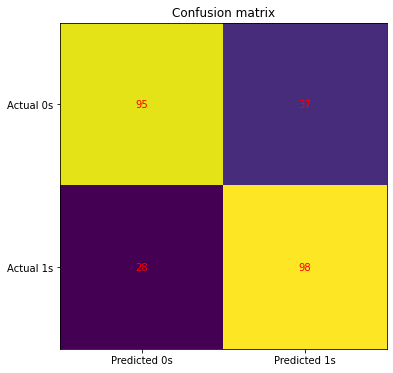

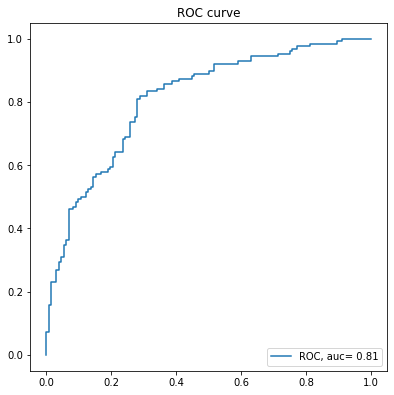

In [40]:
# Model quality analysis
model_quality(model, X_train, X_test, y_train, y_test)

### Logistic regression (Regularization strength = 0.005)

In [8]:
# Create a model and train
model2 = LogisticRegression(solver= 'liblinear', C= 0.005, random_state= 0)
model2.fit(X_train, y_train)

LogisticRegression(C=0.005, random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.75 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       132
           1       0.73      0.77      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[97 35]
 [29 97]]



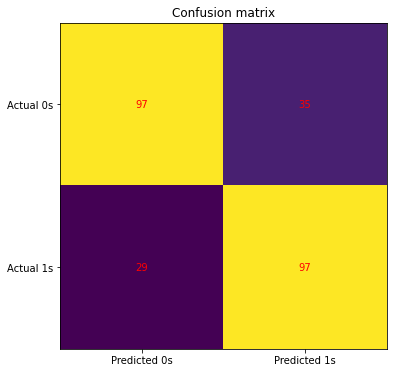

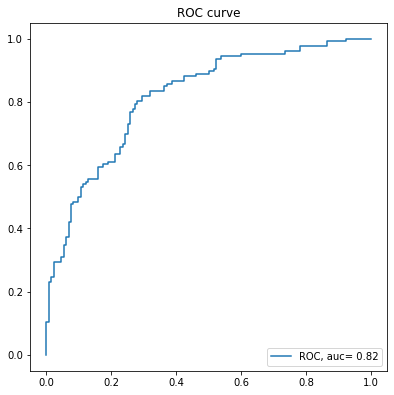

In [38]:
# Model quality analysis
model_quality(model2, X_train, X_test, y_train, y_test)